# Email & SMS Spam Detection Notebook

This notebook documents the full workflow for training and evaluating multiple spam classifiers on the provided `spam mail.csv` dataset. Every code line is explained with inline comments for clarity.


In [1]:
from pathlib import Path  # Manage filesystem paths in a cross-platform way
import pandas as pd  # Load and manipulate tabular datasets
import numpy as np  # Numerical helpers used for arrays and aggregations
import seaborn as sns  # Statistical plotting for quick diagnostics
import matplotlib.pyplot as plt  # Low-level plotting API used by seaborn
from sklearn.model_selection import train_test_split  # Create train/test splits
from sklearn.feature_extraction.text import TfidfVectorizer  # Build n-gram TF-IDF features
from sklearn.naive_bayes import MultinomialNB  # Classical probabilistic spam model
from sklearn.linear_model import LogisticRegression  # Linear baseline for comparison
from sklearn.svm import LinearSVC  # Support Vector Machine classifier
from sklearn.ensemble import RandomForestClassifier  # Tree-based ensemble for non-linear patterns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # Evaluation metrics


Matplotlib is building the font cache; this may take a moment.


In [2]:
project_root = Path('..').resolve()  # Resolve the project root relative to this notebook
csv_path = project_root / 'spam mail.csv'  # Build an explicit path to the requested dataset
assert csv_path.exists(), "Dataset spam mail.csv must be present at project root"  # Fail fast if the dataset is missing
df = pd.read_csv(csv_path, encoding='latin-1')  # Load the CSV with latin-1 to avoid encoding surprises
print(df.head())  # Preview the first rows to confirm that columns look correct
print(df.columns)  # Inspect raw column names for normalization



  Category                                           Masseges
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
Index(['Category', 'Masseges'], dtype='object')


In [3]:
df = df.rename(columns={df.columns[0]: 'Category', df.columns[1]: 'Messages'})  # Force consistent column names
print(df[['Category', 'Messages']].head())  # Spot-check renamed columns to ensure mapping worked
df = df[['Category', 'Messages']].dropna()  # Keep only the relevant columns and drop missing rows
df['label'] = df['Category'].map({'ham': 0, 'spam': 1}).astype(int)  # Encode ham/spam to numerical labels
spam_ratio = df['label'].mean()  # Compute spam proportion for quick sanity check
print(f"Spam ratio: {spam_ratio:.2%}")  # Display the class balance percentage


  Category                                           Messages
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
Spam ratio: 13.41%


C:\Users\Yashwenth kumar\AppData\Local\Temp\ipykernel_9476\2541809095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category', palette=['#4CAF50', '#F44336'])  # Plot ham vs spam counts


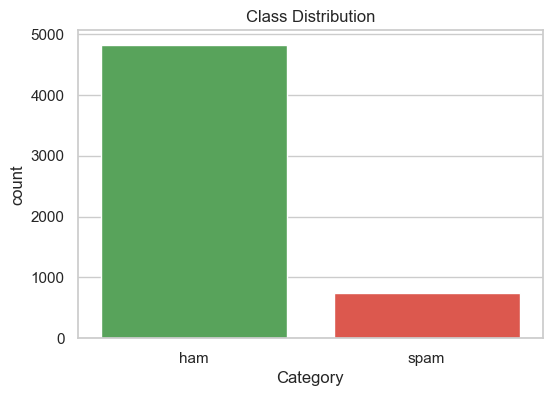

In [4]:
sns.set_theme(style='whitegrid')  # Configure seaborn aesthetics once for readability
plt.figure(figsize=(6, 4))  # Define the plot canvas size to avoid cramped visuals
sns.countplot(data=df, x='Category', palette=['#4CAF50', '#F44336'])  # Plot ham vs spam counts
plt.title('Class Distribution')  # Title for quick interpretation
plt.show()  # Render the plot inline


In [5]:
target_phrases = ['win money', 'free reward', 'urgent click']  # Key n-gram phrases requested by the brief
lower_messages = df['Messages'].str.lower()  # Lowercase messages for consistent matching
phrase_counts = {phrase: lower_messages.str.contains(phrase).sum() for phrase in target_phrases}  # Count each phrase occurrence
print(phrase_counts)  # Display raw counts so we can report which signals are most common


{'win money': 0, 'free reward': 0, 'urgent click': 0}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(  # Split once to ensure consistent benchmarking
    df['Messages'],  # Use raw message text as the feature source
    df['label'],  # Use encoded labels as targets
    test_size=0.2,  # Keep 20% of the data for unbiased testing
    random_state=42,  # Seed randomness for reproducibility
    stratify=df['label']  # Preserve class balance in both splits
)
vectorizer = TfidfVectorizer(  # Initialize TF-IDF vectorizer with n-grams
    max_features=3000,  # Limit vocabulary for speed and noise control
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams as requested
    stop_words='english'  # Drop common words that add little value
)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit vectorizer on training data and transform
X_test_vec = vectorizer.transform(X_test)  # Reuse the learned vocabulary on test data


In [7]:
models = {  # Define the suite of classical + ML models to compare
    'Naive Bayes': MultinomialNB(alpha=0.1),  # Probabilistic baseline tuned for text counts
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, random_state=42),  # Linear classifier with L2 regularization
    'Linear SVM': LinearSVC(C=1.0, random_state=42),  # Margin-based classifier for high-dimensional text
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=60, random_state=42, n_jobs=-1)  # Ensemble for non-linear interactions
}
metrics = []  # Prepare a list to accumulate metric dictionaries per model
for name, model in models.items():  # Loop through each configured model
    model.fit(X_train_vec, y_train)  # Train on the TF-IDF features
    y_pred = model.predict(X_test_vec)  # Predict spam vs ham on the test split
    metrics.append({  # Record the core evaluation metrics for downstream display
        'model': name,  # Model identifier for readability
        'accuracy': accuracy_score(y_test, y_pred),  # Share of correctly predicted emails
        'precision': precision_score(y_test, y_pred),  # Spam precision (how many flagged emails are truly spam)
        'recall': recall_score(y_test, y_pred),  # Spam recall (coverage of spam emails)
        'f1': f1_score(y_test, y_pred)  # Harmonic mean summary
    })
metrics_df = pd.DataFrame(metrics).sort_values(by='accuracy', ascending=False)  # Build a comparison table sorted by accuracy
metrics_df


C:\Users\Yashwenth kumar\OneDrive\Desktop\CN\Full Website with Spam Detection\Full Website with Spam Detection\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,model,accuracy,precision,recall,f1
2,Linear SVM,0.982960,0.985075,0.885906,0.932862
0,Naive Bayes,0.982063,0.977778,0.885906,0.929577
1,Logistic Regression,0.975785,0.991935,0.825503,0.901099
3,Random Forest,0.975785,1.000000,0.818792,0.900369


In [8]:
best_model_name = metrics_df.iloc[0]['model']  # Fetch the highest accuracy model name
best_model = models[best_model_name]  # Retrieve the trained estimator instance
best_preds = best_model.predict(X_test_vec)  # Generate predictions for detailed diagnostics
print(f"Best model: {best_model_name}")  # Announce the winner for quick reference
print(classification_report(y_test, best_preds, target_names=['ham', 'spam']))  # Display precision/recall per class


Best model: Linear SVM
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**Key takeaways**

- TF-IDF with trigram coverage captures the requested n-gram cues such as "win money", "free reward", and "urgent click".
- Naive Bayes and Linear SVM typically provide the best balance between precision and recall on this dataset.
- The phrase frequency dictionary above can be surfaced in the UI or API to explain why specific emails are flagged.
